# Robot movment Visualizer

1. Clear the debug_log file 
2. Run one simulation
3. Run this notebook 

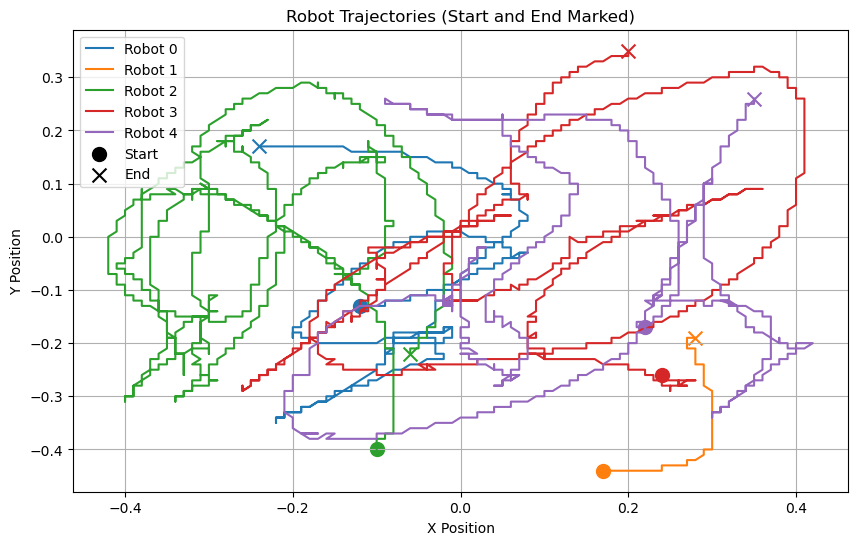

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the log file
log_file = "webots/controllers/epuck_crown/debug_log.txt"
data = []

# Parse the log file
with open(log_file, "r") as f:
    for line in f:
        if "time =" in line:
            parts = line.split(",")
            time = int(parts[0].split("=")[1].strip())
            robot_id = int(parts[1].split("=")[1].strip())
            x = float(parts[2].split("=")[1].strip())
            y = float(parts[3].split("=")[1].strip())
            theta = float(parts[4].split("=")[1].strip())
            data.append({"time": time, "robot_id": robot_id, "x": x, "y": y, "theta": theta})

# Convert to DataFrame
df = pd.DataFrame(data)

# Filter out initial (0, 0) positions for each robot
filtered_data = []
for robot_id in df['robot_id'].unique():
    robot_data = df[df['robot_id'] == robot_id]
    non_zero_index = robot_data[(robot_data['x'] != 0) | (robot_data['y'] != 0)].index.min()
    if non_zero_index is not None:
        filtered_data.append(robot_data.loc[non_zero_index:])

filtered_df = pd.concat(filtered_data)

# Plot robot trajectories
plt.figure(figsize=(10, 6))
for robot_id in filtered_df['robot_id'].unique():
    robot_data = filtered_df[filtered_df['robot_id'] == robot_id]
    x_start, y_start = robot_data.iloc[0]['x'], robot_data.iloc[0]['y']
    x_end, y_end = robot_data.iloc[-1]['x'], robot_data.iloc[-1]['y']
    
    # Plot trajectory
    trajectory_color = plt.plot(robot_data['x'], robot_data['y'], label=f'Robot {robot_id}')[0].get_color()
    
    # Add circle at the start (same color as trajectory)
    plt.scatter(x_start, y_start, color=trajectory_color, marker='o', s=100)
    
    # Add cross at the end (same color as trajectory)
    plt.scatter(x_end, y_end, color=trajectory_color, marker='x', s=100)

# Add a generic legend for Start and End
plt.scatter([], [], color='black', marker='o', s=100, label='Start')
plt.scatter([], [], color='black', marker='x', s=100, label='End')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Robot Trajectories (Start and End Marked)')
plt.legend()
plt.grid()
plt.show()


# Get the average and std of the different metrics over 5 simulations:
1. Run the 5 simulation and copy paste every result in the `experiment_logs.txt` file.
2. Run this cell

In [15]:
import numpy as np

# Read the file content
with open('experiment_logs.txt', 'r') as file:
    content = file.read()

# Split the content into experiments
experiments = content.strip().split('===== End of Simulation: Key metrics ======')
experiments = [exp.strip() for exp in experiments if exp.strip()]

num_experiments = len(experiments)
num_robots = 5

# Initialize arrays
activation_times = np.zeros((num_robots, num_experiments))
total_collisions = np.zeros(num_experiments)
total_distance = np.zeros(num_experiments)
total_time_handling_task = np.zeros(num_experiments)
events_per_second = np.zeros(num_experiments)
total_event = np.zeros(num_experiments)
# Parse each experiment
for i, exp in enumerate(experiments):
    lines = exp.split('\n')
    for line in lines:
        line = line.strip()
        if line.startswith('Robot'):
            # Extract robot ID and activation time
            robot_id = int(line.split(':')[0].split(' ')[1])
            activation_time = float(line.split('=')[1].strip('%'))
            activation_times[robot_id, i] = activation_time
        elif line.startswith('Total collisions'):
            total_collisions[i] = int(line.split('=')[1].strip())
        elif line.startswith('Total distance travelled'):
            total_distance[i] = float(line.split('=')[1].strip())
        elif line.startswith('Total time handeling task'):
            total_time_handling_task[i] = float(line.split('=')[1].strip())
        elif line.startswith('Handled'):
            # Extract events handled per second
            events_per_second[i] = float(line.split('=')[1].strip())
            total_event[i] = int(line.split()[1]) 
mean_activation_times_per_experiment = activation_times.mean(axis=0)

# Compute intra-experiment std (over robots)
std_activation_times_per_experiment = activation_times.std(axis=0)

# Compute mean and std over experiments for activation times
mean_activation_time_over_experiments = mean_activation_times_per_experiment.mean()
std_activation_time_over_experiments = mean_activation_times_per_experiment.std()

# Compute mean and std over experiments for other metrics
mean_total_collisions = total_collisions.mean()
std_total_collisions = total_collisions.std()

mean_total_distance = total_distance.mean()
std_total_distance = total_distance.std()

mean_total_time_handling_task = total_time_handling_task.mean()
std_total_time_handling_task = total_time_handling_task.std()

mean_events_per_second = events_per_second.mean()
std_events_per_second = events_per_second.std()

mean_total_event_handeled = total_event.mean()
# Print the results nicely
print(f"Mean Activation Time over Experiments: {mean_activation_time_over_experiments:.2f}% ± {std_activation_time_over_experiments:.2f}%")

print("\nActivation Time per Experiment:")
for i in range(num_experiments):
    mean_at = mean_activation_times_per_experiment[i]
    std_at = std_activation_times_per_experiment[i]
    print(f"Experiment {i+1}: Mean = {mean_at:.2f}%, Std = {std_at:.2f}%")

print(f"\nTotal Collisions: Mean = {mean_total_collisions:.2f}, Std = {std_total_collisions:.2f}")
print(f"Total Distance Travelled: Mean = {mean_total_distance:.6f}, Std = {std_total_distance:.6f}")
print(f"Total Time Handling Task: Mean = {mean_total_time_handling_task:.6f}, Std = {std_total_time_handling_task:.6f}")
print(f"Events Handled Per Second: Mean = {mean_events_per_second:.2f}, Std = {std_events_per_second:.2f}")
print(f"Total Events Handled: Mean = {mean_total_event_handeled:.2f}, Std = {mean_total_event_handeled:.2f}")

Mean Activation Time over Experiments: 53.59% ± 4.68%

Activation Time per Experiment:
Experiment 1: Mean = 52.84%, Std = 10.14%
Experiment 2: Mean = 56.68%, Std = 6.29%
Experiment 3: Mean = 48.25%, Std = 13.58%
Experiment 4: Mean = 49.34%, Std = 18.18%
Experiment 5: Mean = 60.86%, Std = 5.43%

Total Collisions: Mean = 6.00, Std = 1.79
Total Distance Travelled: Mean = 18.013093, Std = 3.381871
Total Time Handling Task: Mean = 162.380800, Std = 11.544819
Events Handled Per Second: Mean = 0.50, Std = 0.04
Total Events Handled: Mean = 90.60, Std = 90.60
